In [1]:
# Import of libraries

# System libraries
import re
import unicodedata
import itertools

# Library for file manipulation
import pandas as pd
import numpy as np
import pandas

# Data visualization
import seaborn as sns
import matplotlib.pylab as pl
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt

# Machine learning
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity

# Configuration for graph width and layout
sns.set_theme(style='whitegrid')
palette='viridis'

# Warnings remove alerts
import warnings
warnings.filterwarnings("ignore")

# Python version
from platform import python_version
print('Python version in this Jupyter Notebook:', python_version())

# Load library versions
import watermark #type:ignore

# Library versions
%reload_ext watermark
%watermark -a "Library versions" --iversions

Python version in this Jupyter Notebook: 3.12.3
Author: Library versions

matplotlib: 3.10.1
re        : 2.2.1
watermark : 2.5.0
numpy     : 2.2.5
pandas    : 2.2.3
seaborn   : 0.13.2
sklearn   : 1.7.0
platform  : 1.0.8



In [2]:
df=pd.read_csv(r"songs_grouped_by_song.csv")
df.head()

,track_name,playlist_genre,track_album_name,playlist_subgenre,track_artist,duration_ms,popularity_2023,popularity_2025,track_album_release_date,danceability,...,liveness,valence,tempo,season,popularity_categorized,year,period,artist_avg_pop,release_age,artist_song_count
0,"""i tried for years... nobody listened""",rap,war,gangster rap,iceberg black,150909.0,18.0,0.0,2018-09-22,0.914,...,0.116,0.0944,140.0260,Autumn,hardly recognizable,2018,2010s,18.00,7,1
1,"""this is seagull….""",pop,smother earth,electropop,the snake corps,238227.0,34.0,35.0,1990-01-01,0.516,...,0.110,0.2350,135.9030,Winter,famous,1990,1990s,34.00,35,1
2,#1 stunna,rap,i got that work,hip hop; southern hip hop,big tymers,281960.0,24.0,25.5,2000-01-01,0.552,...,0.258,0.5650,89.0435,Winter,famous,2000,2000s,24.25,25,4
3,#nakama,r&b,#nakama,hip pop,xlii,192094.0,26.0,6.0,2019-12-25,0.797,...,0.318,0.5680,108.0410,Winter,hardly recognizable,2019,2010s,26.00,6,1
4,#natural,latin,#natural,latin hip hop,paty cantú,227013.0,50.0,33.0,2017-10-20,0.800,...,0.134,0.8160,97.0230,Autumn,famous,2017,2010s,56.50,8,2


In [14]:
df_all=pd.read_csv(r"2023_songs_cleaned.csv")
df_all.head()

,track_id,track_name,track_artist,popularity_2023,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,instrumentalness,liveness,valence,tempo,duration_ms,popularity_2025,season,year,period,popularity_categorized
0,6ZMda6mscE8eRkuwlw8yFB,bedsitter,soft cell,18,1xza4j8vMQdGqqQdHa30lI,non stop erotic cabaret (deluxe edition),1981-12-18,"Maxi Pop GOLD (New Wave, Electropop, Synth Po...",2nRWtTI9a2LWjJ9Wy3JZs5,pop,...,0.00538,0.0747,0.610,145.271,215333,12,Autumn,1981,1980s,hardly recognizable
1,4GDmAT5ZZyHdBo32UYDIvM,tainted love,soft cell,53,1xza4j8vMQdGqqQdHa30lI,non stop erotic cabaret (deluxe edition),1981-12-18,Classic Rock Radio,4lIywN6kXl9KPm3OQ8u8G7,rock,...,0.00000,0.2920,0.651,144.543,153880,44,Autumn,1981,1980s,famous
2,4bnNwCbIo9vxlIpu88KV0K,der mussolini - 1998 - remaster,daf,2,2nQmZO698ZhHOkxUaCZPJS,alles ist gut,1981-03-18,Gothic / Industrial / Mittelalter / EBM / Futu...,53CmFroG6MWR5reOOXJX6B,pop,...,0.49400,0.1160,0.867,156.308,235107,0,Winter,1981,1980s,hardly recognizable
3,6KrMDGTp9CtkMLKyftDUTD,wavelength - remastered,van morrison,44,47nhRTYeYBKV5mEfXLV4fb,wavelength,1978-09-18,Classic Rock Retrogamer,6gUFdcGzKAHyDXY9TKC6cP,rock,...,0.00115,0.4630,0.522,142.829,346987,22,Summer,1978,1970s,hardly recognizable
4,3JXOMZdeJ7uMR7UfC3BN5T,top of the bill - live,scorpions,2,3fWEWigB3tgsGAUN4kNIKf,tokyo tapes (50th anniversary deluxe edition),1978-08-18,This Is Scorpions,37i9dQZF1DWViGKI2U5P2K,rock,...,0.67500,0.9130,0.232,142.665,407333,0,Summer,1978,1970s,hardly recognizable


EDA

In [3]:
from sklearn.preprocessing import MultiLabelBinarizer

# Split genres and subgenres into lists
df['genre_list'] = df['playlist_genre'].str.split(';')
df['subgenre_list'] = df['playlist_subgenre'].str.split(';')

# --- Genre encoding ---
mlb_genre = MultiLabelBinarizer()
genre_encoded = pd.DataFrame(mlb_genre.fit_transform(df['genre_list']),
                             columns=mlb_genre.classes_,
                             index=df.index)

# Drop first genre if desired
genre_encoded = genre_encoded.drop(columns=mlb_genre.classes_[0])

# --- Subgenre encoding ---
mlb_subgenre = MultiLabelBinarizer()
subgenre_encoded = pd.DataFrame(mlb_subgenre.fit_transform(df['subgenre_list']),
                                columns=mlb_subgenre.classes_,
                                index=df.index)

# Drop first subgenre if desired
subgenre_encoded = subgenre_encoded.drop(columns=mlb_subgenre.classes_[0])

# --- Other categorical features ---
dummies_other = pd.get_dummies(df[['period','season']], drop_first=True)

# --- Combine all categorical features ---
categorical_features = pd.concat([genre_encoded, subgenre_encoded, dummies_other], axis=1)


numeric_cols = [
    'danceability', 'energy', 'key', 'loudness', 'mode',
    'speechiness', 'acousticness', 'instrumentalness',
    'liveness', 'valence', 'tempo', 'duration_ms',
    'popularity_2025'
]




In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df[numeric_cols])
# Combine all
X = np.concatenate([X_scaled, categorical_features.values], axis=1)

# Optional: save feature names for reference
feature_names = numeric_cols + list(categorical_features.columns)

In [5]:
print(X.shape)  # (n_songs, n_features)
print(df[['track_name', 'playlist_genre']].head())
print(np.mean(X, axis=0)[:5])  # check scaling


(23052, 78)
                               track_name playlist_genre
0  "i tried for years... nobody listened"            rap
1                     "this is seagull…."            pop
2                               #1 stunna            rap
3                                 #nakama            r&b
4                                #natural          latin
[0.6667985275157368 0.6970160063876909 0.489541432019319
 0.8299067575216393 0.5642894325871942]


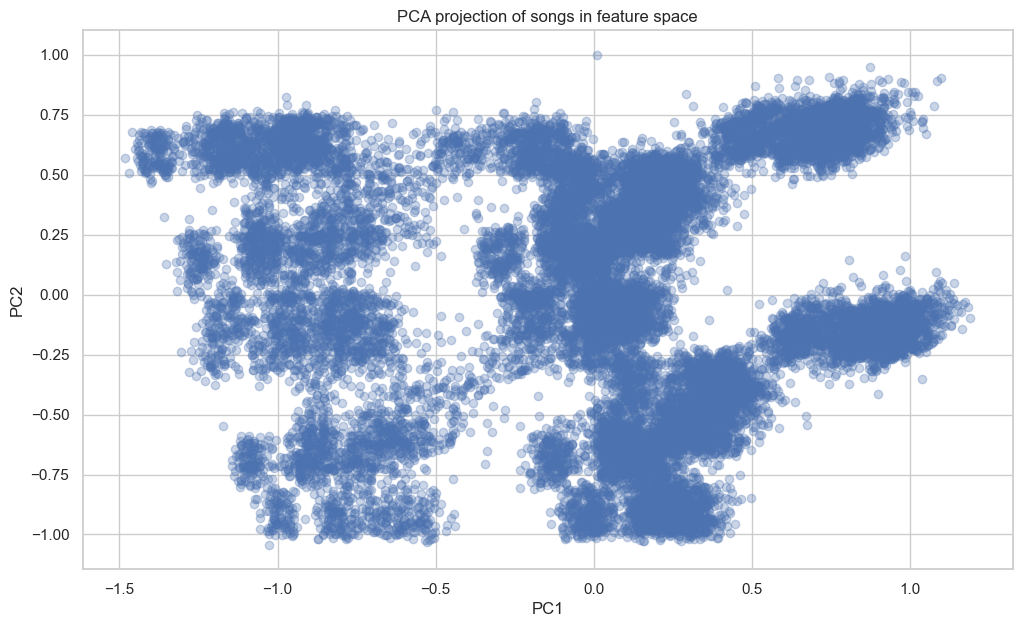

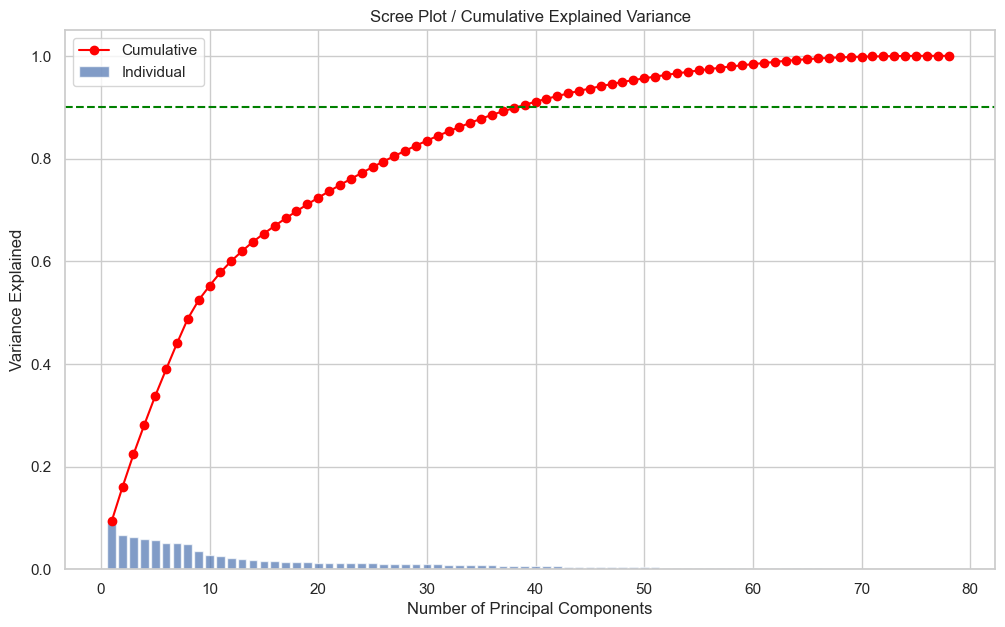

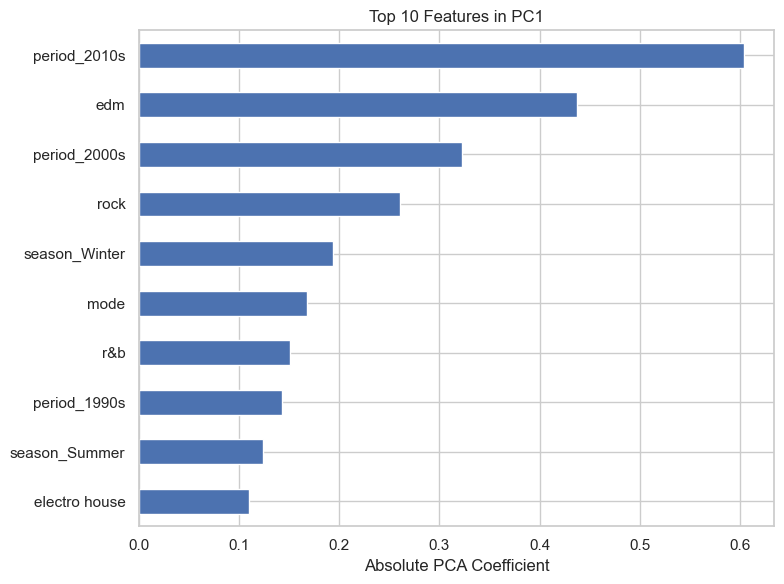

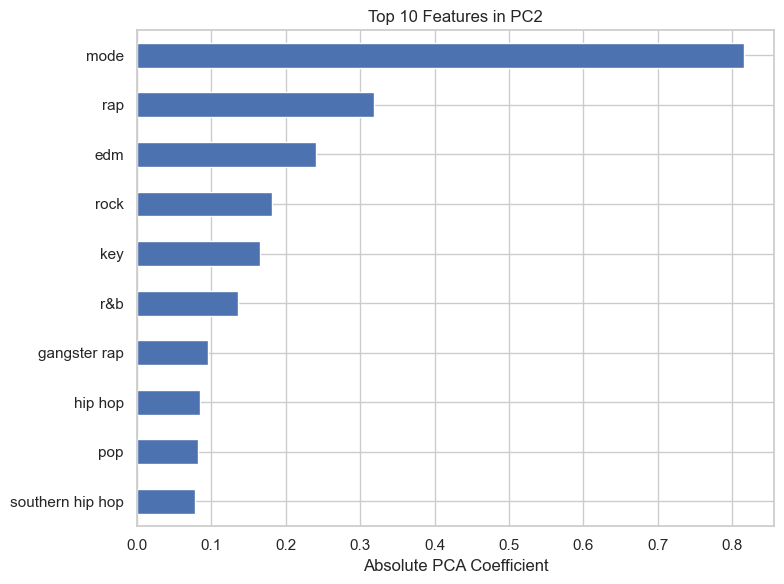

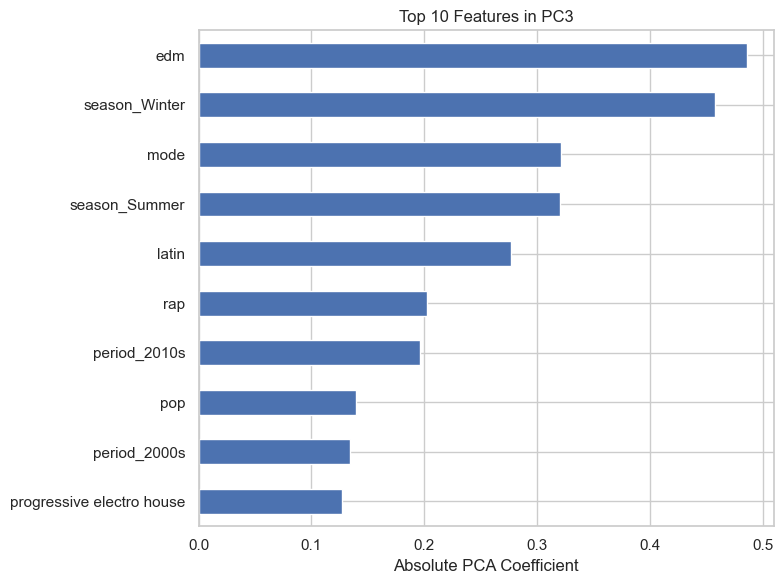

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

# Fit PCA on the scaled features
pca = PCA()
X_pca = pca.fit_transform(X)

# Scatter plot of first two components
plt.figure(figsize=(12,7))
plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.3)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA projection of songs in feature space')
plt.show()

# Variance explained by each component
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Scree plot
plt.figure(figsize=(12,7))
plt.bar(range(1, len(explained_variance)+1), explained_variance, alpha=0.7, label='Individual')
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o', color='red', label='Cumulative')
plt.xlabel('Number of Principal Components')
plt.ylabel('Variance Explained')
plt.title('Scree Plot / Cumulative Explained Variance')
plt.legend()
plt.grid(True)
plt.axhline(0.9,color="green", linestyle="--", label='90% variance')
plt.show()

# --- Feature importance per component ---
# pca.components_ has shape (n_components, n_features)
# Use absolute values to see contribution magnitude
feature_importance = np.abs(pca.components_)

# Convert to DataFrame for easier plotting
feature_importance_df = pd.DataFrame(feature_importance.T, 
                                     index=feature_names,  # your original feature names
                                     columns=[f'PC{i+1}' for i in range(feature_importance.shape[0])])

# Plot top 10 features for the first 3 principal components
for i in range(3):
    pc_importance = feature_importance_df.iloc[:, i]
    top_features = pc_importance.sort_values(ascending=False).head(10)
    
    plt.figure(figsize=(8,6))
    top_features.plot(kind='barh')
    plt.title(f'Top 10 Features in PC{i+1}')
    plt.xlabel('Absolute PCA Coefficient')
    plt.gca().invert_yaxis()  # highest on top
    plt.tight_layout()
    plt.show()





In [7]:
# Determine number of components to retain 90% variance
n_components_90 = np.argmax(cumulative_variance >= 0.9) + 1
print(f"Number of components to retain 90% variance: {n_components_90}")

# Re-fit PCA with the optimal number of components
pca_90 = PCA(n_components=n_components_90)
X_pca_90 = pca_90.fit_transform(X)

Number of components to retain 90% variance: 39


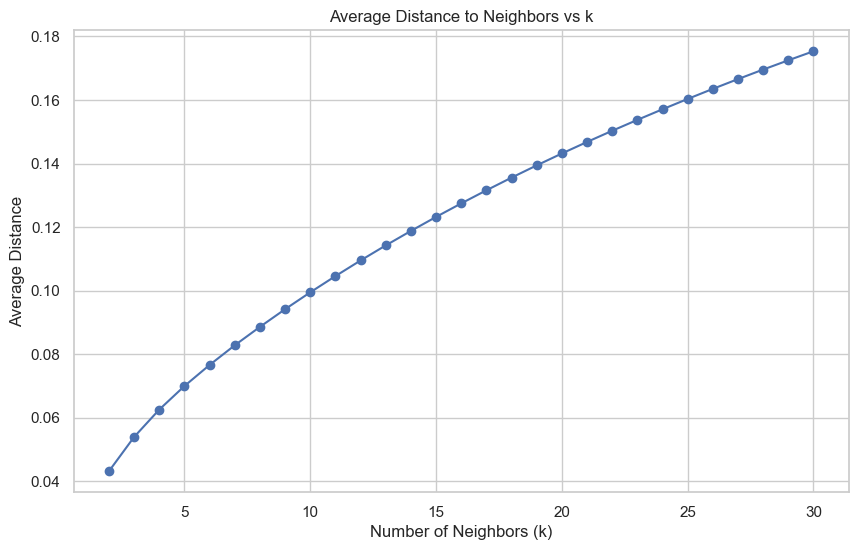

Best value of k: 1
Top-1 recommended track indices for track 0:
[0]


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# Suppose X_pca_90 has shape (22000, 15) after PCA
# Sample a subset to speed up k-search (e.g., 5000 tracks)
sample_size = 5000
np.random.seed(42)
sample_indices = np.random.choice(X_pca_90.shape[0], size=sample_size, replace=False)
X_sample = X_pca_90[sample_indices, :]

# List of k values to test
k_values = list(range(1, 31))
mean_distances = []

# Loop to find the best k
for k in k_values:
    model = NearestNeighbors(n_neighbors=k, metric='cosine')
    model.fit(X_sample)
    
    # Compute distances to nearest neighbors
    distances, indices = model.kneighbors(X_sample)
    
    # Average distance (excluding self-distance at index 0)
    mean_distance = np.mean(distances[:, 1:])  
    mean_distances.append(mean_distance)

# Plotting the average distance metric for different values of k
plt.figure(figsize=(10, 6))
plt.plot(k_values, mean_distances, marker='o')
plt.title('Average Distance to Neighbors vs k')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Average Distance')
plt.grid(True)
plt.show()

# Find best k (minimizes average distance)
best_k = k_values[np.argmin(mean_distances)]
print(f"Best value of k: {best_k}")

# --- Train final KNN model on full dataset ---
knn_model = NearestNeighbors(n_neighbors=best_k, metric='cosine')
knn_model.fit(X_pca_90)

# --- Example: get top-k recommended tracks for a given track index ---
track_idx = 0  # change to any track index
distances, neighbors = knn_model.kneighbors(X_pca_90[track_idx].reshape(1, -1))
print(f"Top-{best_k} recommended track indices for track {track_idx}:")
print(neighbors.flatten())


In [ ]:
# # --- PARAMETERS ---
# k_neighbors = 10  # Number of neighbors to recommend per track

# # --- Fit KNN model on all PCA features ---
# knn_model = NearestNeighbors(n_neighbors=k_neighbors, metric='cosine')
# knn_model.fit(X_pca_90)  # X_pca_90: (n_tracks, n_pca_features)

# # --- Function: Recommend top-k tracks based on track name ---
# def recommend_tracks_by_name(track_name, top_k=k_neighbors):
#     # Find the first track that matches the name (case-insensitive, partial match)
#     matched_idx = df.index[df['track_name'].str.contains(track_name, case=False, na=False)].tolist()
    
#     if not matched_idx:
#         print(f"No track found matching '{track_name}'")
#         return
    
#     track_idx = matched_idx[0]
#     track_real_name = df.loc[track_idx, 'track_name']
    
#     # Find top-k neighbors using PCA features
#     distances, neighbors = knn_model.kneighbors(X_pca_90[track_idx].reshape(1, -1), n_neighbors=top_k+1)
    
#     # Remove the query track itself (distance=0)
#     neighbors_idx = neighbors.flatten()[1:]
#     neighbors_distances = distances.flatten()[1:]
    
#     print(f"Recommendations for track '{track_real_name}':")
#     for i, idx in enumerate(neighbors_idx):
#         recommended_name = df.loc[idx, 'track_name']
#         print(f"{i+1}. {recommended_name} (distance: {neighbors_distances[i]:.4f})")
    
#     return neighbors_idx, neighbors_distances

# # --- EXAMPLE ---
# recommend_tracks_by_name("horse")


given the impracticality of just having only one recommended song just by average distance from neighbors, a higher value of k such as k=5 or k=10 will be chosen to diversify the selection of similar songs.

In [15]:
from sklearn.metrics.pairwise import cosine_similarity

# --- PARAMETERS ---
k_neighbors = 10  # Number of neighbors to recommend per track

# --- Fit KNN model on all PCA features ---
knn_model = NearestNeighbors(n_neighbors=k_neighbors, metric='cosine')
knn_model.fit(X_pca_90)  # X_pca_90: (n_tracks, n_pca_features)


# Create implicit feedback: 1 if track in playlist, or weighted by popularity
interaction_matrix = df_all.pivot_table(
    index='playlist_id', 
    columns='track_id', 
    values='popularity_2025',  # optional: can use 1 instead
    fill_value=0
)

print(interaction_matrix.shape)  # rows = playlists, cols = tracks

# Compute similarity between tracks based on playlist co-occurrence
item_similarity = cosine_similarity(interaction_matrix.T)
item_similarity_df = pd.DataFrame(
    item_similarity,
    index=interaction_matrix.columns,
    columns=interaction_matrix.columns
)

(471, 28297)


In [51]:
def recommend_tracks_hybrid_verbose(track_name, top_k=10, alpha=0.5):
    """
    Hybrid recommendation (content PCA KNN + playlist CF) with full metrics displayed.
    
    Returns a DataFrame with:
    - track_name
    - track_id
    - content_similarity (from PCA KNN)
    - cf_similarity (from playlist co-occurrence)
    - hybrid_score (combined)
    """
    # --- Find the track in df (content) ---
    matched_idx = df.index[df['track_name']==track_name].tolist()
    if not(matched_idx):
        matched_idx = df.index[df['track_name'].str.contains(track_name, case=False, na=False)].tolist()

    if not matched_idx:
        print(f"No track found matching '{track_name}'")
        return
    track_name_real = df.loc[matched_idx[0], 'track_name']
    
    # --- Map to df_all track_ids for CF ---
    track_ids = df_all.loc[df_all['track_name'] == track_name_real, 'track_id'].unique()
    if len(track_ids) == 0:
        print(f"No track_id found in df_all for '{track_name_real}'")
        return
    track_id = track_ids[0]
    
    # --- Content-based scores ---
    distances, neighbors_idx = knn_model.kneighbors(
        X_pca_90[matched_idx[0]].reshape(1, -1), n_neighbors=50
    )
    content_similarity = pd.Series(
        1 - distances.flatten(),  # convert distance -> similarity
        index=df.loc[neighbors_idx.flatten(), 'track_name']
    )
    
    # --- CF-based scores ---
    cf_similarity = item_similarity_df.loc[track_id]
    
    # --- Normalize both to [0,1] ---
    content_similarity = (content_similarity - content_similarity.min()) / (content_similarity.max() - content_similarity.min())
    cf_similarity = (cf_similarity - cf_similarity.min()) / (cf_similarity.max() - cf_similarity.min())
    
    # --- Map content score track_name to track_id ---
    content_ids = []
    for tn in content_similarity.index:
        ids = df_all.loc[df_all['track_name'] == tn, 'track_id'].unique()
        content_ids.append(ids[0] if len(ids) > 0 else None)
    content_similarity.index = content_ids
    
    # --- Combine ---
    hybrid_score = alpha * content_similarity.add(cf_similarity, fill_value=0) + (1 - alpha) * cf_similarity
    
    # --- Top-k tracks ---
    top_recs_ids = hybrid_score.sort_values(ascending=False).head(top_k+1).index
    
    # --- Build result DataFrame with all metrics ---
    recs_df = df_all[df_all['track_id'].isin(top_recs_ids)][['track_name', 'track_id']].drop_duplicates()
    recs_df = recs_df.set_index('track_id')
    recs_df['content_similarity'] = content_similarity.reindex(recs_df.index)
    recs_df['cf_similarity'] = cf_similarity.reindex(recs_df.index)
    recs_df['hybrid_score'] = hybrid_score.reindex(recs_df.index)
    # recs_df.fillna(0,inplace=True)
    # --- Sort by hybrid_score ---
    recs_df = recs_df.sort_values('hybrid_score', ascending=False)
    
    print(f"Top {top_k} hybrid recommendations for '{track_name_real}':")
    # print(recs_df)
    
    return recs_df


In [36]:
def recommend_tracks_hybrid_verbose(track_name, top_k=10, alpha=0.5):
    """
    Hybrid recommendation (content PCA KNN + playlist CF) with full metrics displayed.
    alpha=1->pure collaborative-filtering
    alpha=0->pure content-based
    Returns a DataFrame with:
    - track_name
    - track_id
    - content_distance (from PCA KNN)
    - content_similarity (from PCA KNN)
    - cf_similarity (from playlist co-occurrence)
    - hybrid_score (combined)
    """
    # --- Find the track in df (content) ---
    matched_idx = df.index[df['track_name'].str.contains(track_name, case=False, na=False)].tolist()
    if not matched_idx:
        print(f"No track found matching '{track_name}'")
        return
    track_idx = matched_idx[0]
    track_name_real = df.loc[track_idx, 'track_name']
    
    # --- Map to df_all track_ids for CF ---
    track_ids = df_all.loc[df_all['track_name'] == track_name_real, 'track_id'].unique()
    if len(track_ids) == 0:
        print(f"No track_id found in df_all for '{track_name_real}'")
        return
    track_id = track_ids[0]
    
    # --- Content-based KNN ---
    distances, neighbors_idx = knn_model.kneighbors(
        X_pca_90[track_idx].reshape(1, -1), n_neighbors=50
    )
    neighbors_idx = neighbors_idx.flatten()[1:]
    distances = distances.flatten()[1:]
    content_similarity = pd.Series(1 - distances, index=df.loc[neighbors_idx, 'track_name'])
    content_distance = pd.Series(distances, index=df.loc[neighbors_idx, 'track_name'])
    
    # --- Normalize content similarities ---
    content_similarity = (content_similarity - content_similarity.min()) / (content_similarity.max() - content_similarity.min())
    
    # --- Map content names -> track_ids ---
    content_ids = []
    for tn in content_similarity.index:
        ids = df_all.loc[df_all['track_name'] == tn, 'track_id'].unique()
        content_ids.append(ids[0] if len(ids) > 0 else None)
    content_similarity.index = content_ids
    content_distance.index = content_ids
    
    # Drop those with no ID
    content_similarity = content_similarity.dropna()
    content_distance = content_distance.dropna()
    
    # --- CF similarity ---
    cf_similarity = item_similarity_df.loc[track_id]
    cf_similarity = (cf_similarity - cf_similarity.min()) / (cf_similarity.max() - cf_similarity.min())
    
    # --- Combine only over common IDs ---
    all_ids = set(content_similarity.index).union(cf_similarity.index)
    content_aligned = content_similarity.reindex(all_ids, fill_value=0)
    cf_aligned = cf_similarity.reindex(all_ids, fill_value=0)
    
    # --- Hybrid score ---
    hybrid_score = alpha * content_aligned + (1 - alpha) * cf_aligned
    
    # --- Build results ---
    recs_df = (
        df_all[df_all['track_id'].isin(all_ids)]
        .drop_duplicates(subset='track_id')
        .set_index('track_id')[['track_name']]
    )
    recs_df['content_distance'] = content_distance.reindex(recs_df.index)
    recs_df['content_similarity'] = content_aligned.reindex(recs_df.index)
    recs_df['cf_similarity'] = cf_aligned.reindex(recs_df.index)
    recs_df['hybrid_score'] = hybrid_score.reindex(recs_df.index)
    
    # --- Sort by hybrid_score ---
    recs_df = recs_df.sort_values('hybrid_score', ascending=False).head(top_k)
    
    print(f"Top {top_k} hybrid recommendations for '{track_name_real}':")
    print(recs_df)
    
    return recs_df


In [53]:
recommend_tracks_hybrid_verbose("the search",top_k=10,alpha=1)

Top 10 hybrid recommendations for 'the search is over':


,track_name,content_similarity,cf_similarity,hybrid_score
track_id,,,,
10b7RJ4vWHQFxpTikfsf6A,the search is over,1.000000,1.0,2.000000
6BtlcfCWVBUEZwFaNJ0QMO,i can't hold back,0.898626,1.0,1.898626
6LDRTOMCSx81hKXAk1LuHd,at this moment,0.865703,1.0,1.865703
3LVRM23d9ltvRoquuZy1Yb,love touch - 2008 remaster,0.284574,1.0,1.284574
4ybDW0xfRBCPwsjwFOUzZW,no more lonely nights,0.016744,1.0,1.016744
1cOj24fUMnBSXhtp7waHVW,that's what friends are for,NaN,1.0,1.000000
7LoGfKBAaOl0nxhodJ1240,word up,NaN,1.0,1.000000
6yJxCltgtmGxIgKOS6ndnu,greatest love of all,NaN,1.0,1.000000
1lJZSsMoWEbrgaY6CxPMf8,would i lie to you? - remastered version,NaN,1.0,1.000000


<h3>Clustering<h3>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

# --- Step 1: Choose PCA-reduced features ---
X_cluster = X_pca_90  # (already computed)

# --- Step 2: K-Means Clustering with Silhouette Optimization ---
sil_scores = []
K_range = range(2, 15)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_cluster)
    sil = silhouette_score(X_cluster, labels)
    sil_scores.append(sil)

best_k = K_range[np.argmax(sil_scores)]
print(f"Best k for KMeans based on silhouette: {best_k}")

# Fit final KMeans model
kmeans_final = KMeans(n_clusters=best_k, random_state=42)
kmeans_labels = kmeans_final.fit_predict(X_cluster)

In [ ]:
# --- Step 3: DBSCAN Clustering (optional tuning) ---
eps_values = np.linspace(0.1, 2.0, 20)
best_eps = None
best_sil = -1

for eps in eps_values:
    db = DBSCAN(eps=eps, min_samples=10).fit(X_cluster)
    if len(set(db.labels_)) > 1 and -1 not in set(db.labels_):  # exclude all noise or single cluster
        sil = silhouette_score(X_cluster, db.labels_)
        if sil > best_sil:
            best_sil = sil
            best_eps = eps

if best_eps:
    print(f"Best eps for DBSCAN: {best_eps:.2f} (silhouette={best_sil:.3f})")
    db_final = DBSCAN(eps=best_eps, min_samples=10)
    db_labels = db_final.fit_predict(X_cluster)
else:
    db_labels = np.array([-1]*len(X_cluster))

In [ ]:
# --- Step 4: Agglomerative Clustering (try a few k values) ---
sil_agg = []
for k in K_range:
    agg = AgglomerativeClustering(n_clusters=k)
    labels = agg.fit_predict(X_cluster)
    sil_agg.append(silhouette_score(X_cluster, labels))

best_k_agg = K_range[np.argmax(sil_agg)]
print(f"Best k for Agglomerative Clustering: {best_k_agg}")

agg_final = AgglomerativeClustering(n_clusters=best_k_agg)
agg_labels = agg_final.fit_predict(X_cluster)


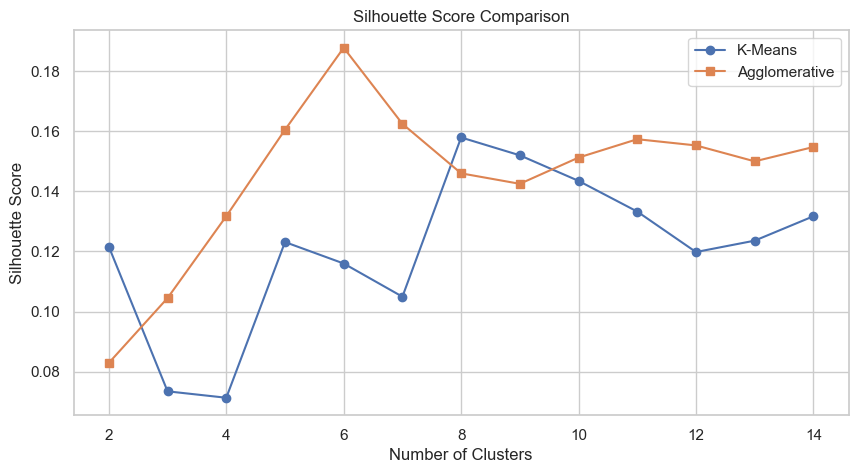

In [49]:
# --- Compare models ---
plt.figure(figsize=(10, 5))
plt.plot(K_range, sil_scores, marker='o', label='K-Means')
plt.plot(K_range, sil_agg, marker='s', label='Agglomerative')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Comparison')
plt.legend()
plt.show()


Looking at the K-means algorithm, the optimal number of clusters is k=8, whereas for the hierarchical clustering k=6 achieves the highest silhouette score. Hence, based on Silhouette Score metric Agglomerative (hierarchical) clustering barely outperforms K-means.

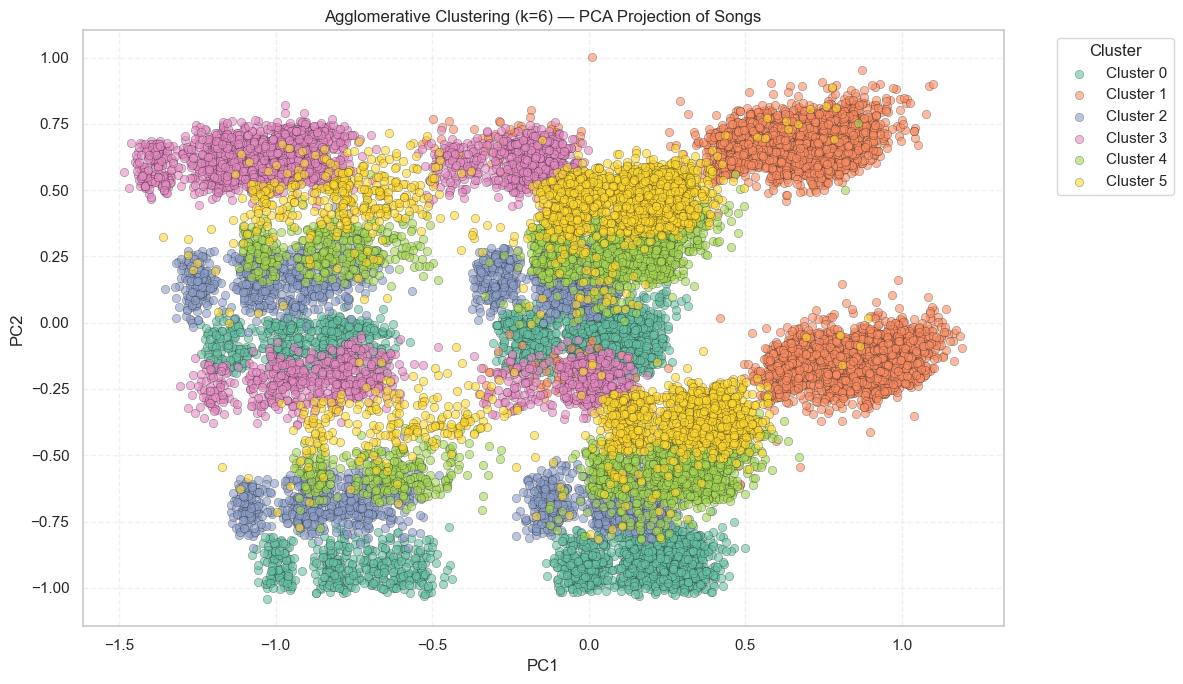

In [37]:
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import seaborn as sns

# Fit Agglomerative model with 6 clusters
agg = AgglomerativeClustering(n_clusters=6)
labels_agg = agg.fit_predict(X_pca_90)

# Plot clusters
palette = sns.color_palette("Set2", n_colors=6)
plt.figure(figsize=(12,7))
for i in range(6):
    plt.scatter(X_pca[:,0][labels_agg==i],
                X_pca[:,1][labels_agg==i],
                color=palette[i], label=f'Cluster {i}', alpha=0.6, edgecolor='k', linewidth=0.3)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Agglomerative Clustering (k=6) — PCA Projection of Songs')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


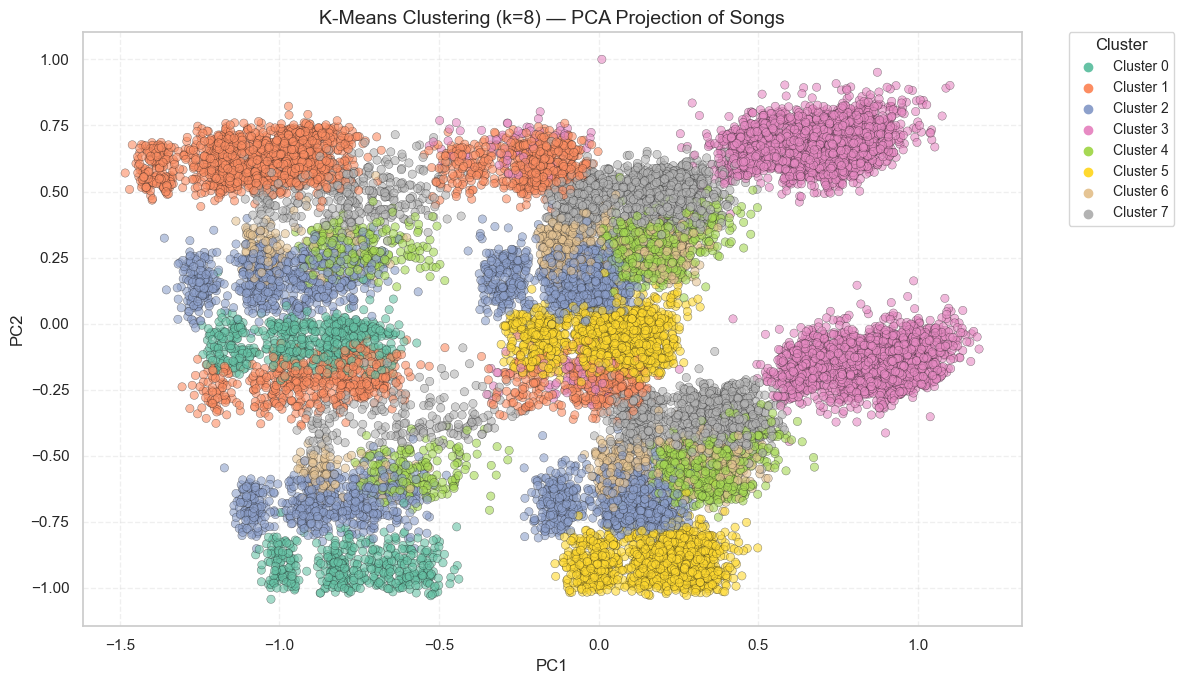

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Define a distinct color palette for exactly 8 clusters
palette = sns.color_palette("Set2", n_colors=8)  # or "tab10", "Paired", "Accent"

# Map cluster labels to colors
colors = [palette[label] for label in kmeans_labels]

plt.figure(figsize=(12,7))
scatter = plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=colors,
    alpha=0.6,
    edgecolor="k",
    linewidth=0.3
)

# Custom colorbar with discrete labels
# Create custom handles for legend instead of colorbar
for i in range(8):
    plt.scatter([], [], color=palette[i], label=f'Cluster {i}')

plt.legend(
    title='Cluster',
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0.,
    fontsize=10
)

plt.xlabel('PC1', fontsize=12)
plt.ylabel('PC2', fontsize=12)
plt.title('K-Means Clustering (k=8) — PCA Projection of Songs', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


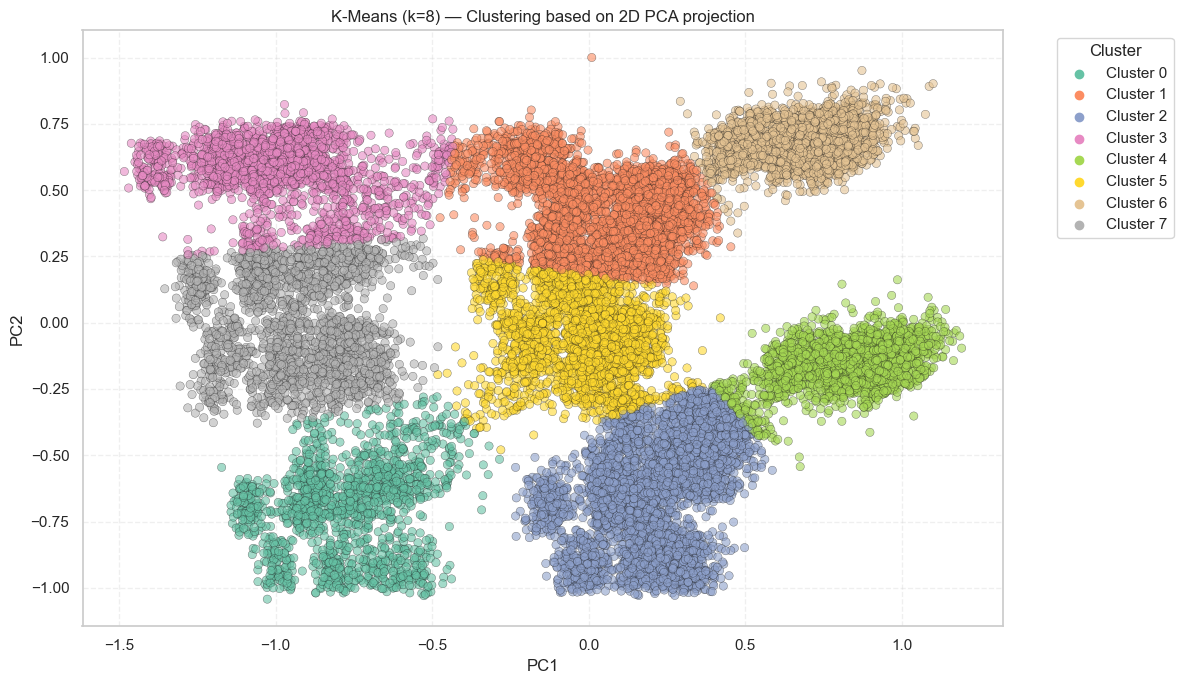

In [35]:
# Cluster on 2D PCA instead of high-dimensional space
kmeans_2d = KMeans(n_clusters=8, random_state=42)
labels_kmeans_2d = kmeans_2d.fit_predict(X_pca[:, :2])

# Plot again
palette = sns.color_palette("Set2", n_colors=8)
colors = [palette[label] for label in labels_kmeans_2d]

plt.figure(figsize=(12,7))
plt.scatter(X_pca[:,0], X_pca[:,1], c=colors, alpha=0.6, edgecolor='k', linewidth=0.3)
for i in range(8):
    plt.scatter([], [], color=palette[i], label=f'Cluster {i}')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('K-Means (k=8) — Clustering based on 2D PCA projection')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


In [42]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np

# assuming X is your data
X_scaled = StandardScaler().fit_transform(X)

dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

unique_labels = np.unique(dbscan_labels)
print("Unique cluster labels:", unique_labels)
print("Number of clusters (excluding noise):", len(unique_labels[unique_labels != -1]))
print("Noise points:", np.sum(dbscan_labels == -1))


Unique cluster labels: [-1]
Number of clusters (excluding noise): 0
Noise points: 23052


In [48]:
for eps in [0.8, 1.2,1.25,1.4, 1.5,1.6,1.7,2]:
    db = DBSCAN(eps=eps, min_samples=5)
    labels = db.fit_predict(X_scaled)
    print(f"eps={eps}, clusters={len(set(labels))- (1 if -1 in labels else 0)}, noise={np.sum(labels==-1)}")


eps=0.8, clusters=0, noise=23052
eps=1.2, clusters=5, noise=23024
eps=1.25, clusters=8, noise=23009
eps=1.4, clusters=29, noise=22866
eps=1.5, clusters=52, noise=22653
eps=1.6, clusters=86, noise=22278
eps=1.7, clusters=140, noise=21621
eps=2, clusters=243, noise=18826


Density based clustering did not find any dense and clearly seperated clusters to work with, hence we'll have to drop it.

<h3>cluster interpretation / general profiling phase <h3>

In [ ]:
#add clustering encoded labels for each algorithm
df["cluster_label_kmeans"] = kmeans_labels
df["cluster_label_hierarchical"]=agg_labels

In [77]:
#cluster distribution
cluster_label_kmeans_dist=df["cluster_label_kmeans"].value_counts()
cluster_label_hierarchical_dist=df["cluster_label_hierarchical"].value_counts()
print(cluster_label_kmeans_dist)
print("\n\n")
print(cluster_label_hierarchical_dist)

cluster_label_kmeans
3    5016
2    3537
7    3472
5    3155
1    3041
4    2284
6    1508
0    1039
Name: count, dtype: int64



cluster_label_hierarchical
1    5017
0    4140
4    3873
5    3698
2    3283
3    3041
Name: count, dtype: int64


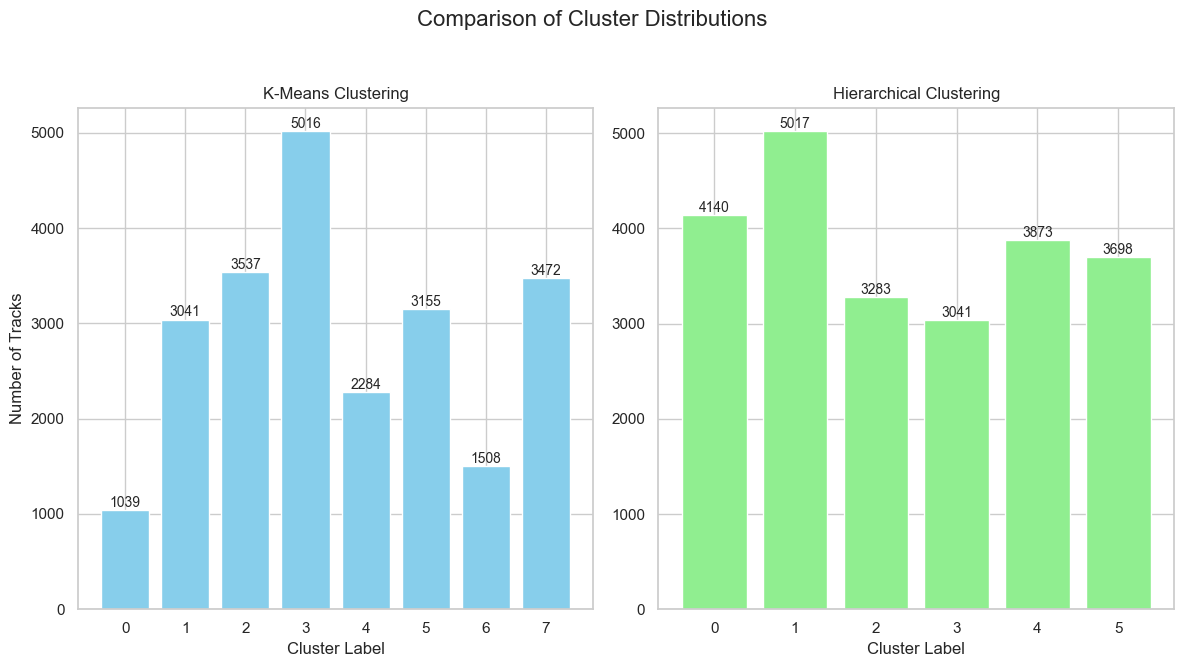

In [101]:
fig,(ax1,ax2)=plt.subplots(nrows=1,ncols=2,figsize=(12,7))

fig.suptitle('Comparison of Cluster Distributions', fontsize=16)

# --- Plot 1: K-Means ---
bars1=ax1.bar(x=cluster_label_kmeans_dist.index, height=cluster_label_kmeans_dist.values, color='skyblue')
ax1.set_title('K-Means Clustering')
ax1.set_xlabel('Cluster Label')
ax1.set_ylabel('Number of Tracks')
# Add data labels on top of each bar
for bar in bars1:
    height=bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width() / 2,  # x-position (center of the bar)
        height + 0.5,                       # y-position (slightly above the bar)
        f"{int(height)}",                   # label text
        ha="center", va="bottom", fontsize=10
    )
# --- Plot 2: Hierarchical ---
bars2=ax2.bar(x=cluster_label_hierarchical_dist.index, height=cluster_label_hierarchical_dist.values, color='lightgreen')
ax2.set_title('Hierarchical Clustering')
ax2.set_xlabel('Cluster Label')
# Add data labels on top of each bar
for bar in bars2:
    height=bar.get_height()
    ax2.text(
        bar.get_x() + bar.get_width() / 2,  # x-position (center of the bar)
        height + 0.5,                       # y-position (slightly above the bar)
        f"{int(height)}",                   # label text
        ha="center", va="bottom", fontsize=10
    )

# Automatically adjust subplot params so that the subplot(s) fits in to the figure area.
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle

plt.show()

In [ ]:
pd.set_option("display.max_columns",None)

In [76]:
cluster_mean_summary_kmeans = df.groupby("cluster_label_kmeans").mean(numeric_only=True)
cluster_mean_summary_hierarchical = df.groupby("cluster_label_hierarchical").mean(numeric_only=True)


In [73]:
cluster_summary_kmeans=df.select_dtypes("number").groupby("cluster_label_kmeans").agg(["mean", "std"]).drop(columns="cluster_label_hierarchical")
cluster_summary_kmeans

duration_ms               popularity_2023             \
                               mean           std            mean        std   
cluster_label_kmeans                                                           
0                     258743.854203  54196.896533       34.179275  20.649429   
1                     247428.743396  66193.747779       39.797380  22.600554   
2                     238916.824389  58544.137893       37.209485  22.875687   
3                     225799.303539  69278.377931       34.475535  21.464970   
4                     221918.969163  49166.132421       45.425886  23.684492   
5                     197131.550222  55205.605072       42.846566  20.917352   
6                     214449.761157  49134.412216       40.391311  20.178074   
7                     221360.937966  47940.501241       42.506897  22.300069   

                     popularity_2025            danceability            \
                                mean        std         mean       std   
cluster_label_kmeans                                                     
0                          28.556465  23.617523     0.738296  0.133570   
1                          28.188108  28.093017     0.516154  0.141388   
2                          24.840121  23.736774     0.668617  0.138688   
3                          16.864861  20.021474     0.658756  0.119134   
4                          28.509859  25.200977     0.715119  0.114581   
5                          18.019171  21.592261     0.704849  0.137185   
6                          23.271711  23.048478     0.700805  0.122703   
7                          24.530537  25.211397     0.630720  0.129721   

                        energy                 key            loudness  \
                          mean       std      mean       std      mean   
cluster_label_kmeans                                                     
0                     0.696057  0.146900  5.656400  3.655747 -7.002146   
1                     0.730639  0.197851  5.332456  3.537528 -7.602087   
2                     0.591131  0.179132  5.443596  3.573050 -7.974088   
3                     0.789341  0.137916  5.347289  3.595861 -5.653857   
4                     0.712876  0.146954  5.597198  3.622545 -6.145327   
5                     0.633481  0.179261  5.308716  3.732465 -7.273524   
6                     0.691506  0.163893  5.307029  3.619314 -6.983967   
7                     0.692384  0.178936  5.307892  3.633048 -6.698472   

                                    mode           speechiness            \
                           std      mean       std        mean       std   
cluster_label_kmeans                                                       
0                     2.990760  0.563041  0.496249    0.234301  0.123690   
1                     3.342735  0.693193  0.461244    0.058265  0.045767   
2                     2.880416  0.524738  0.499458    0.121452  0.109220   
3                     2.347544  0.523923  0.499477    0.088477  0.069174   
4                     2.496983  0.545534  0.498031    0.114994  0.093549   
5                     3.137363  0.514739  0.499862    0.189752  0.136796   
6                     3.473711  0.578249  0.494003    0.088676  0.079862   
7                     2.763769  0.601671  0.489625    0.074987  0.068255   

                     acousticness           instrumentalness            \
                             mean       std             mean       std   
cluster_label_kmeans                                                     
0                        0.116671  0.150912         0.016218  0.100119   
1                        0.154440  0.221103         0.071467  0.188155   
2                        0.265895  0.255851         0.029880  0.121163   
3                        0.091994  0.146850         0.213032  0.316812   
4                        0.201695  0.197299         0.030795  0.128352   
5                        0.226402  0.236581         0.105644  0.266250   
6         

In [75]:
cluster_summary_hierarchical=df.select_dtypes("number").groupby("cluster_label_hierarchical").agg(["mean", "std"]).drop(columns="cluster_label_kmeans")
cluster_summary_hierarchical

duration_ms               popularity_2023  \
                                     mean           std            mean   
cluster_label_hierarchical                                                
0                           212164.919094  61042.485142       40.712065   
1                           225825.419681  69326.764769       34.532379   
2                           240116.169080  59140.938589       36.320946   
3                           247428.743396  66193.747779       39.797380   
4                           218428.555468  49269.988755       43.777684   
5                           222189.639774  47949.921980       42.425540   

                                      popularity_2025            danceability  \
                                  std            mean        std         mean   
cluster_label_hierarchical                                                      
0                           21.217135       20.600415  22.582314     0.714919   
1                           21.530779       16.934582  20.112091     0.659625   
2                           22.749212       24.373327  23.587588     0.667939   
3                           22.600554       28.188108  28.093017     0.516154   
4                           22.641776       26.653850  24.643312     0.711297   
5                           21.998230       24.570059  24.969090     0.628262   

                                        energy                 key            \
                                 std      mean       std      mean       std   
cluster_label_hierarchical                                                     
0                           0.136439  0.647790  0.174082  5.396860  3.717330   
1                           0.118935  0.788872  0.138210  5.354594  3.597086   
2                           0.138764  0.589021  0.181193  5.431617  3.570369   
3                           0.141388  0.730639  0.197851  5.332456  3.537528   
4                           0.118467  0.700846  0.154942  5.492641  3.624342   
5                           0.128871  0.692052  0.177602  5.301785  3.628741   

                            loudness                mode            \
                                mean       std      mean       std   
cluster_label_hierarchical                                           
0                          -7.213723  3.108915  0.524879  0.499441   
1                          -5.656102  2.349242  0.522224  0.499556   
2                          -8.001664  2.905838  0.523302  0.499533   
3                          -7.602087  3.342735  0.693193  0.461244   
4                          -6.502424  2.943619  0.556416  0.496871   
5                          -6.738049  2.761573  0.604110  0.489107   

                           speechiness           acousticness            \
                                  mean       std         mean       std   
cluster_label_hierarchical                                                
0                             0.202257  0.135103     0.200079  0.224278   
1                             0.088714  0.069456     0.092507  0.147408   
2                             0.120560  0.109905     0.270727  0.259657   
3                             0.058265  0.045767     0.154440  0.221103   
4                             0.107531  0.091116     0.217756  0.215258   
5                             0.075047  0.067403     0.179166  0.224645   

                           instrumentalness            liveness            \
                                       mean       std      mean       std   
cluster_label_hierarchical                                                  
0                                  0.083538  0.240345  0.192060  0.149054   
1                                  0.212517  0.316610  0.208905  0.166450   
2                                  0.029851  0.122973  0.176517  0.140716   
3                                  0.071467  0.188155  0.209442  0.180414   
4                                  0.050425  0.176342  0.

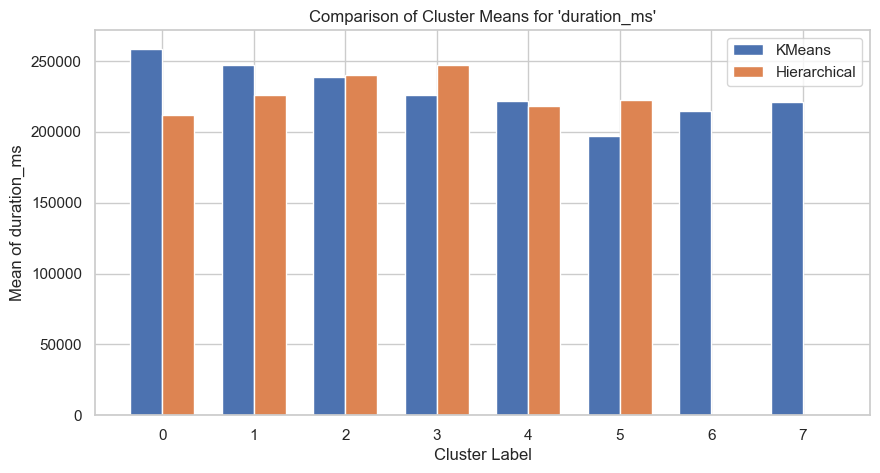

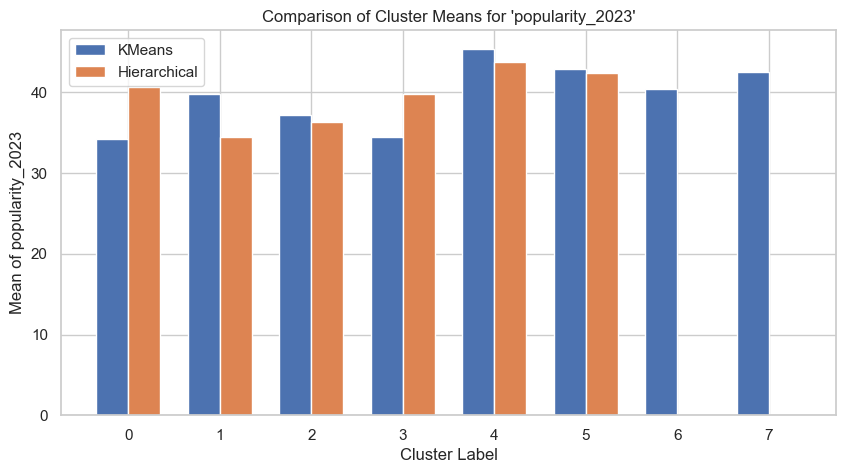

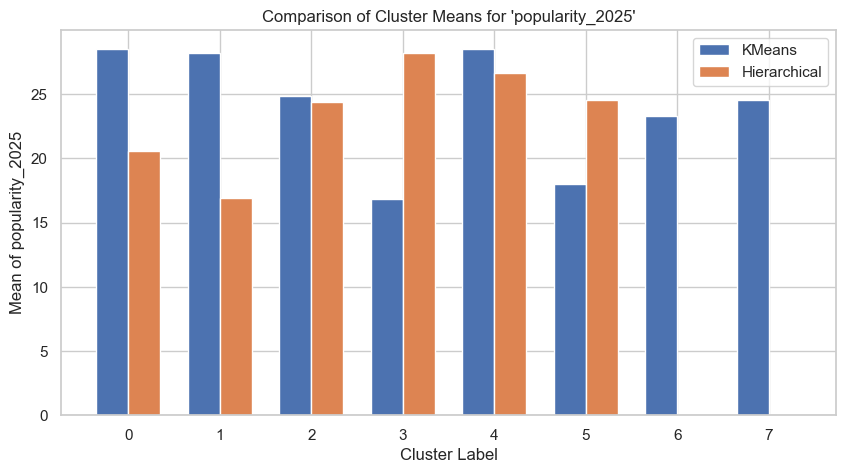

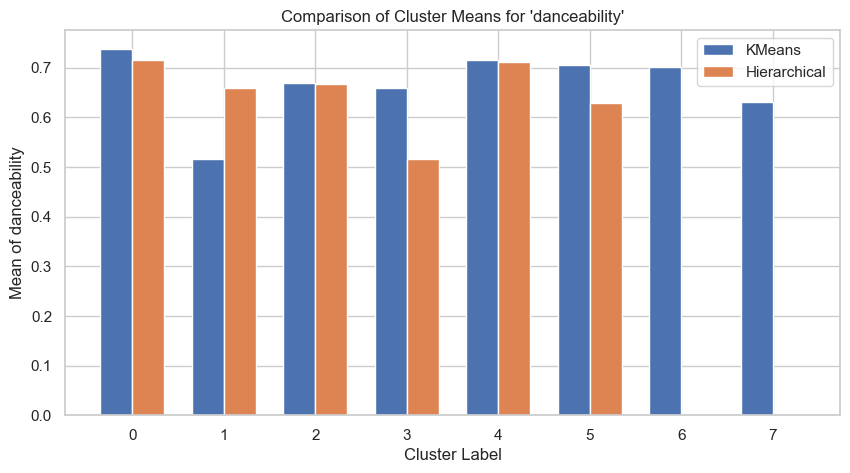

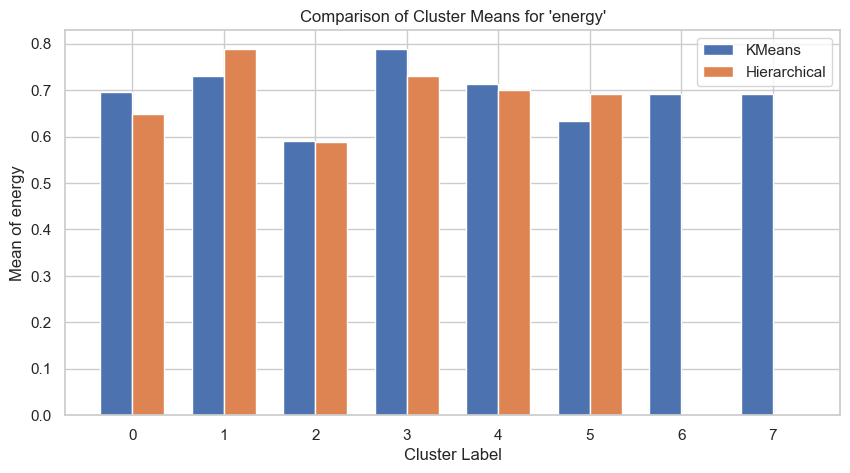

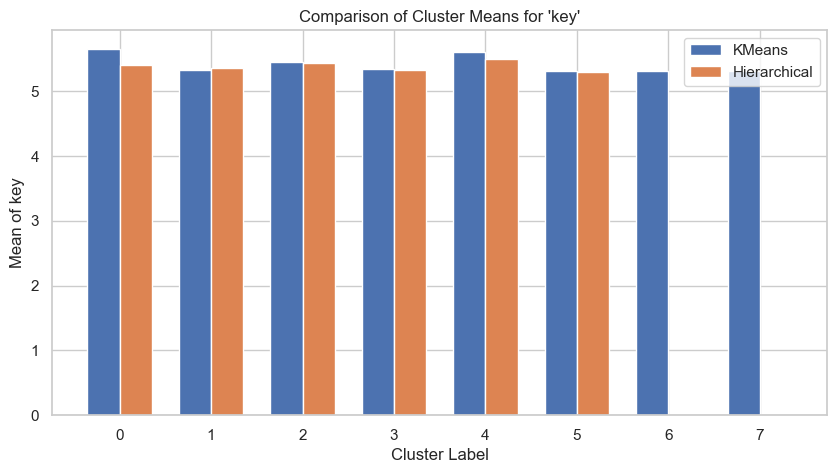

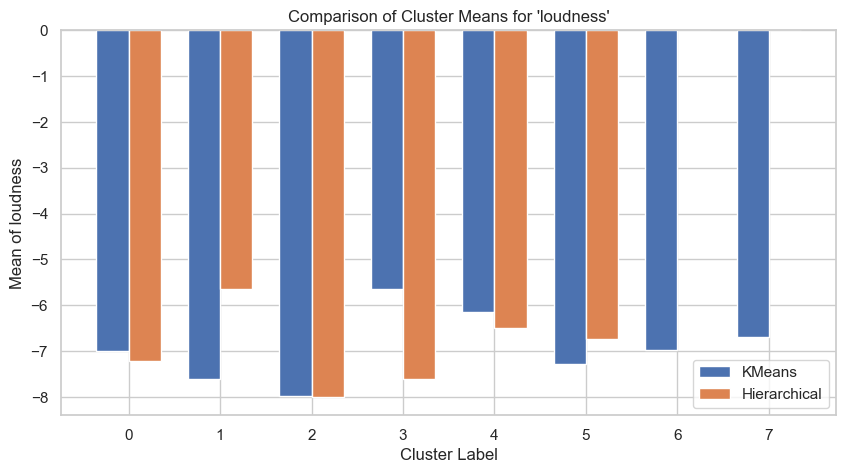

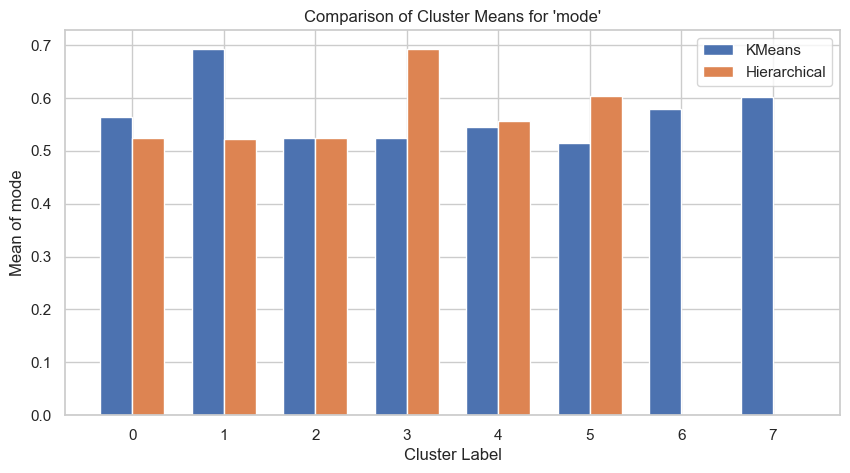

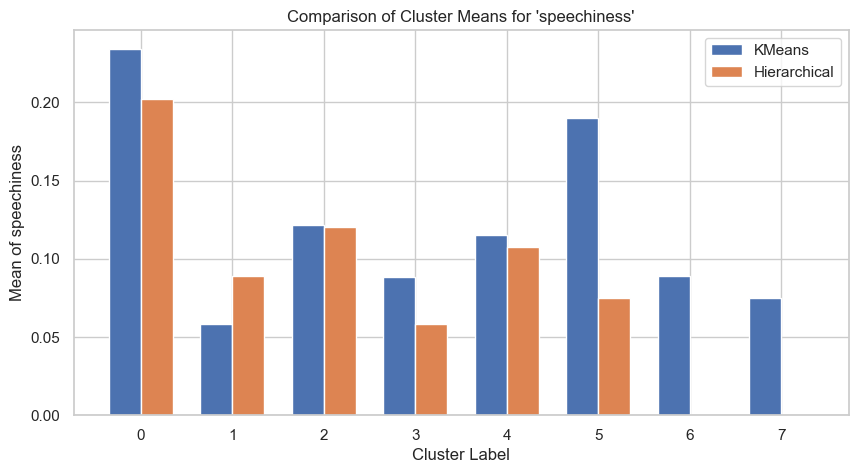

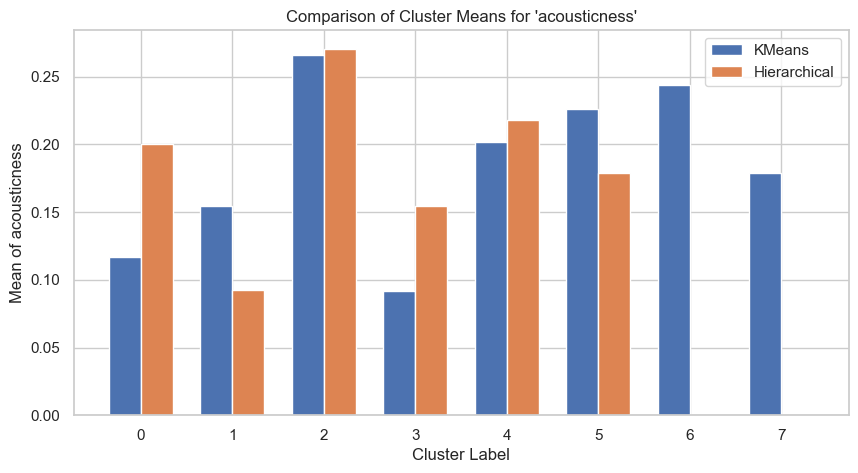

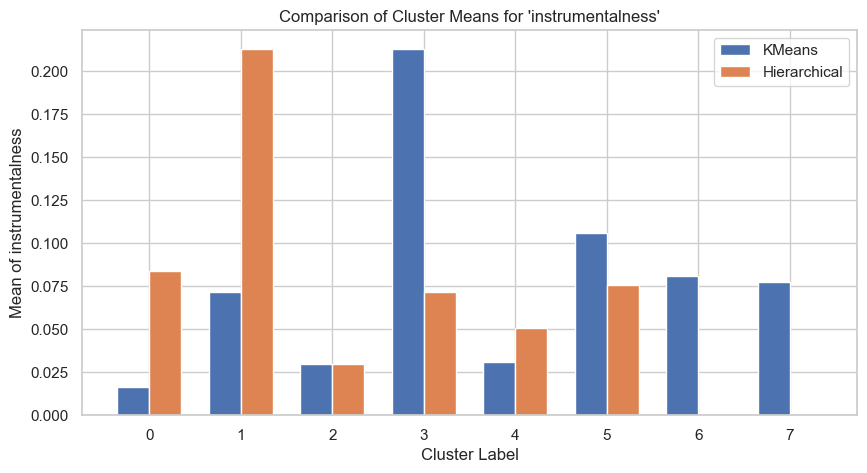

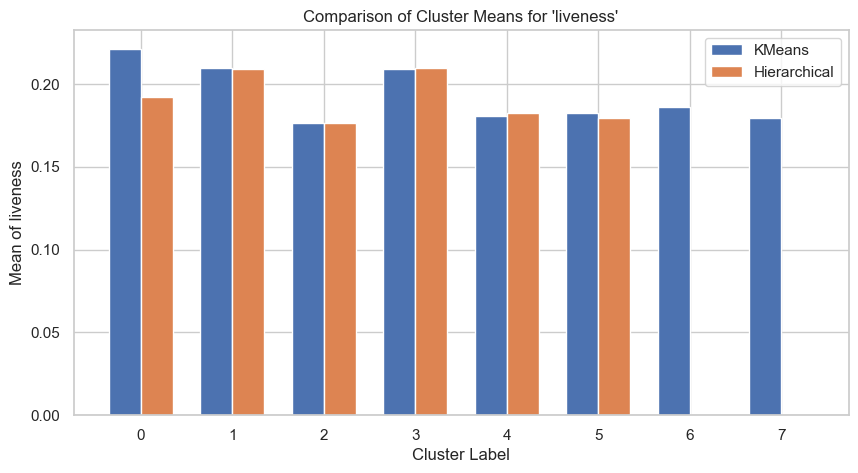

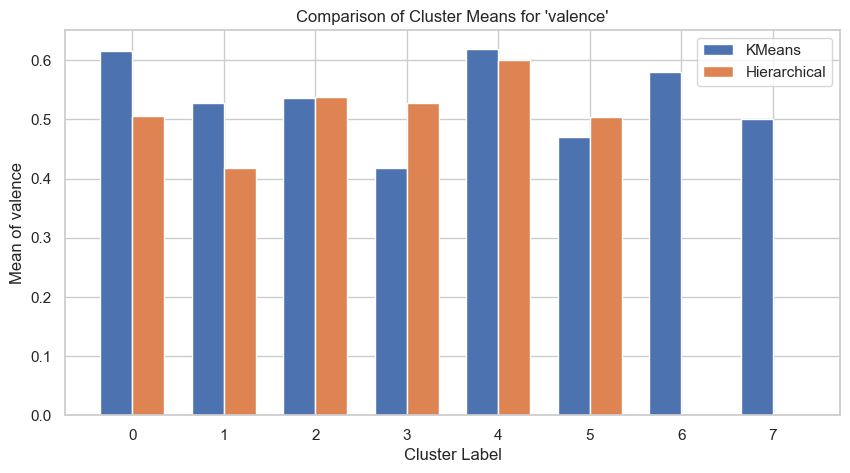

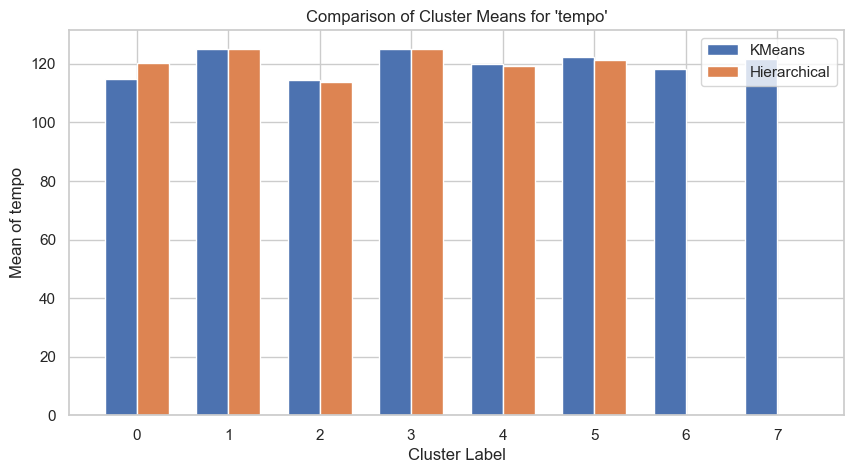

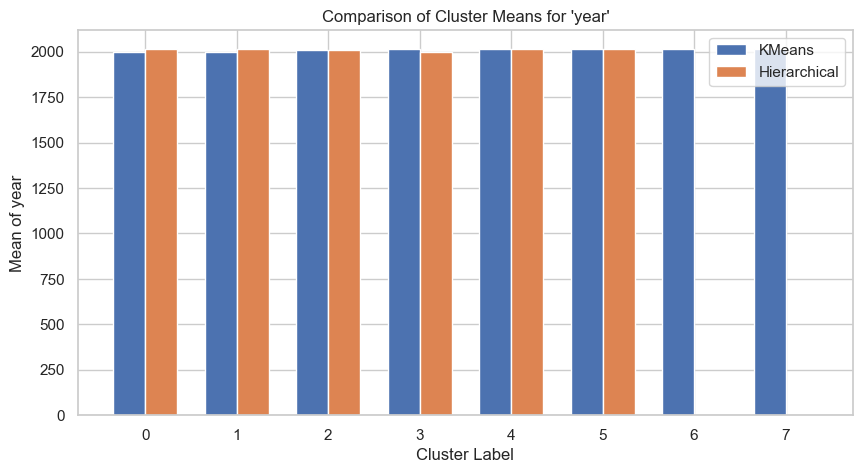

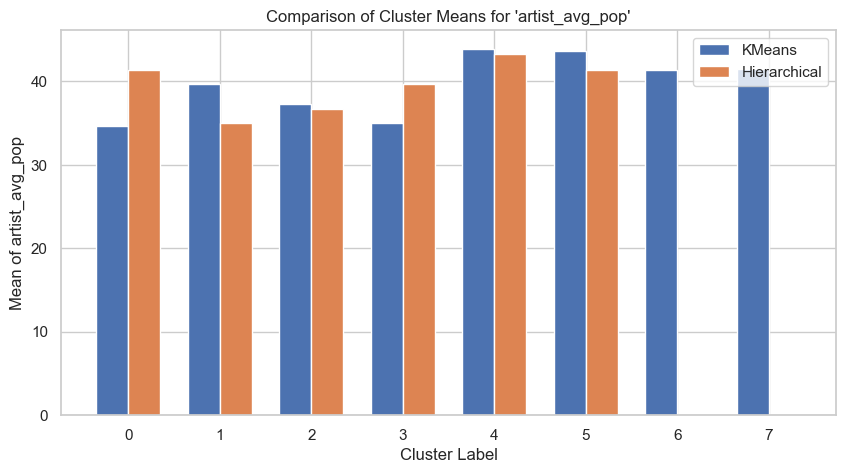

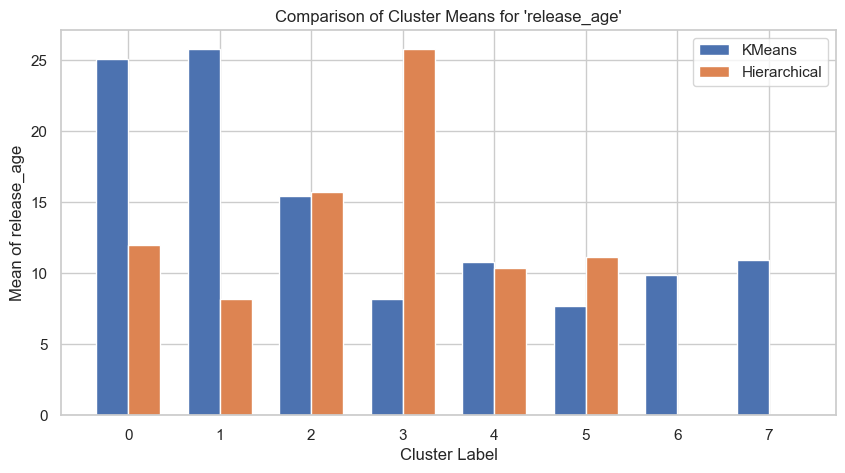

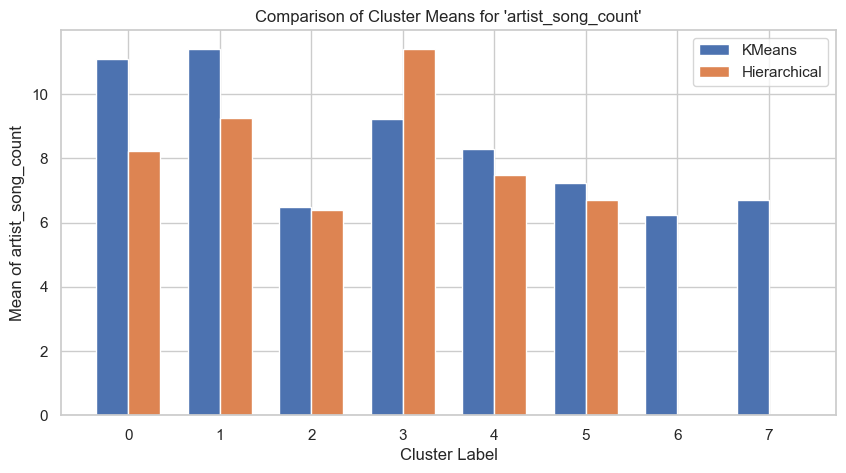

In [108]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

num_cols = df.select_dtypes("number").columns.drop(["cluster_label_kmeans", "cluster_label_hierarchical"])

for col in num_cols:
    # Combine cluster labels
    all_clusters = sorted(set(cluster_summary_kmeans.index) | set(cluster_summary_hierarchical.index))
    
    # Reindex to make sure both series have the same cluster index
    kmeans_means = cluster_summary_kmeans[col]["mean"].reindex(all_clusters, fill_value=0)
    hier_means = cluster_summary_hierarchical[col]["mean"].reindex(all_clusters, fill_value=0)
    
    x = np.arange(len(all_clusters))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(10,5))
    
    ax.bar(x - width/2, kmeans_means, width, label='KMeans')
    ax.bar(x + width/2, hier_means, width, label='Hierarchical')
    
    ax.set_xlabel("Cluster Label")
    ax.set_ylabel(f"Mean of {col}")
    ax.set_title(f"Comparison of Cluster Means for '{col}'")
    ax.set_xticks(x)
    ax.set_xticklabels(all_clusters)
    ax.legend()
    
    plt.show()



In [114]:
cluster_cat_kmeans = df.groupby("cluster_label_kmeans")[df.select_dtypes("object").columns.tolist()].apply(lambda x: x.mode().iloc[0])
cluster_cat_hierarchical = df.groupby("cluster_label_hierarchical")[df.select_dtypes("object").columns.tolist()].apply(lambda x: x.mode().iloc[0])


In [115]:
cluster_cat_kmeans

,track_name,playlist_genre,track_album_name,playlist_subgenre,track_artist,track_album_release_date,season,popularity_categorized,period,genre_list,subgenre_list
cluster_label_kmeans,,,,,,,,,,,
0,#1 stunna,rap,greatest hits,southern hip hop,the notorious b.i.g.,1998-01-01,Winter,famous,2000s,[rap],[southern hip hop]
1,$20 fine,rock,greatest hits,hard rock,queen,2005-01-01,Autumn,hardly recognizable,2010s,[rock],[hard rock]
2,#nakama,r&b,greatest hits,neo soul,the weeknd,2008-01-01,Winter,hardly recognizable,2010s,[r&b],[neo soul]
3,#vivalawldkdz (roberto rosso remix) [feat. twe...,edm,trip stories,progressive electro house,martin garrix,2019-12-06,Autumn,hardly recognizable,2010s,[edm],[progressive electro house]
4,#natural,latin,ultimate freestyle mega mix,latin hip hop,gloria estefan,2019-11-15,Autumn,hardly recognizable,2010s,[latin],[latin hip hop]
5,"""i tried for years... nobody listened""",rap,confessions of a dangerous mind,hip hop,logic,2019-12-20,Autumn,hardly recognizable,2010s,[rap],[hip hop]
6,#summerlovin,latin,x 100pre,tropical,don omar,2010-01-01,Winter,hardly recognizable,2010s,[latin],[tropical]
7,"""this is seagull….""",pop,sweetener,indie poptimism,javiera mena,2010-01-01,Autumn,hardly recognizable,2010s,[pop],[indie poptimism]


In [116]:
cluster_cat_hierarchical

,track_name,playlist_genre,track_album_name,playlist_subgenre,track_artist,track_album_release_date,season,popularity_categorized,period,genre_list,subgenre_list
cluster_label_hierarchical,,,,,,,,,,,
0,"""i tried for years... nobody listened""",rap,greatest hits,southern hip hop,logic,1998-01-01,Autumn,hardly recognizable,2010s,[rap],[southern hip hop]
1,#vivalawldkdz (roberto rosso remix) [feat. twe...,edm,trip stories,progressive electro house,martin garrix,2019-12-06,Autumn,hardly recognizable,2010s,[edm],[progressive electro house]
2,#nakama,r&b,greatest hits,neo soul,janet jackson,2008-01-01,Winter,hardly recognizable,2010s,[r&b],[neo soul]
3,$20 fine,rock,greatest hits,hard rock,queen,2005-01-01,Autumn,hardly recognizable,2010s,[rock],[hard rock]
4,#natural,latin,ultimate freestyle mega mix,latin hip hop,don omar,2012-01-01,Autumn,hardly recognizable,2010s,[latin],[latin hip hop]
5,"""this is seagull….""",pop,sweetener,indie poptimism,javiera mena,2010-01-01,Autumn,hardly recognizable,2010s,[pop],[indie poptimism]
